In [1]:
import numpy as np
import astropy.io.fits as pf
import piff
import matplotlib.pyplot as plt
import galsim
import logging
import pandas
import os
import ngmix
import functions as f
%matplotlib inline

In [2]:
BAD_MEASUREMENT = 2
MAX_CENTROID_SHIFT = 1.0
CENTROID_SHIFT = 4
logger = logging.getLogger('run_piff')

In [3]:
# from run_piff script
def hsm(im, wt, logger):
    #print('im stats: ',im.array.min(),im.array.max(),im.array.mean(),np.median(im.array))
    #print('wt = ',wt)
    #if wt:
        #print('im stats: ',wt.array.min(),wt.array.max(),wt.array.mean(),np.median(wt.array))
    flag = 0
    try:
        shape_data = im.FindAdaptiveMom(weight=wt, strict=False)
        #print('shape_data = ',shape_data)
    except Exception as e:
        logger.info(e)
        logger.info(' *** Bad measurement (caught exception).  Mask this one.')
        flag |= BAD_MEASUREMENT

    if shape_data.moments_status != 0:
        logger.info('status = %s',shape_data.moments_status)
        logger.info(' *** Bad measurement (hsm status).  Mask this one.')
        flag |= BAD_MEASUREMENT

    if galsim.__version__ >= '1.5.1':
        dx = shape_data.moments_centroid.x - im.true_center.x
        dy = shape_data.moments_centroid.y - im.true_center.y
    else:
        dx = shape_data.moments_centroid.x - im.trueCenter().x
        dy = shape_data.moments_centroid.y - im.trueCenter().y
    #print('dx, dy = ',dx,dy)
    if dx**2 + dy**2 > MAX_CENTROID_SHIFT**2:
        logger.info(' *** Centroid shifted by %f,%f in hsm.  Mask this one.',dx,dy)
        flag |= CENTROID_SHIFT

    flux = shape_data.moments_amp
    #print('flux = ',flux)

    # Account for the image wcs
    if im.wcs.isPixelScale():
        g1 = shape_data.observed_shape.g1
        g2 = shape_data.observed_shape.g2
        T = 2 * shape_data.moments_sigma**2 * im.scale**2
        #print('simple shape = ',g1,g2,T)
    else:
        e1 = shape_data.observed_shape.e1
        e2 = shape_data.observed_shape.e2
        s = shape_data.moments_sigma
        #print('simple shape = ',e1,e2,s)

        if galsim.__version__ >= '1.5.1':
            jac = im.wcs.jacobian(im.true_center)
        else:
            jac = im.wcs.jacobian(im.trueCenter())
        M = np.matrix( [[ 1 + e1, e2 ], [ e2, 1 - e1 ]] ) * s*s
        J = jac.getMatrix()
        M = J * M * J.T

        e1 = (M[0,0] - M[1,1]) / (M[0,0] + M[1,1])
        e2 = (2.*M[0,1]) / (M[0,0] + M[1,1])
        T = M[0,0] + M[1,1]

        shear = galsim.Shear(e1=e1, e2=e2)
        g1 = shear.g1
        g2 = shear.g2
        #print('distorted shape = ',g1,g2,T)

    return dx, dy, g1, g2, T, flux, flag

In [4]:
# from run_piff script
def make_ngmix_prior(T, pixel_scale):
    from ngmix import priors, joint_prior

    # centroid is 1 pixel gaussian in each direction
    cen_prior=priors.CenPrior(0.0, 0.0, pixel_scale, pixel_scale)

    # g is Bernstein & Armstrong prior with sigma = 0.1
    gprior=priors.GPriorBA(0.1)

    # T is log normal with width 0.2
    Tprior=priors.LogNormal(T, 0.2)

    # flux is the only uninformative prior
    Fprior=priors.FlatPrior(-10.0, 1.e10)

    prior=joint_prior.PriorSimpleSep(cen_prior, gprior, Tprior, Fprior)
    
    return prior

In [5]:
# from run_piff script
def ngmix_fit(im, wt, fwhm, x, y, logger):
    flag = 0
    dx, dy, g1, g2, flux = 0., 0., 0., 0., 0.
    T_guess = (fwhm / 2.35482)**2 * 2.
    T = T_guess
    try:
        if galsim.__version__ >= '1.5.1':
            wcs = im.wcs.local(im.center)
        else:
            wcs = im.wcs.local(im.center())
#         print('set wcs')
#         print(T, wcs.minLinearScale())
        prior = make_ngmix_prior(T, wcs.minLinearScale())
#         print('made prior')
        if galsim.__version__ >= '1.5.1':
            cen = im.true_center - im.origin
        else:
            cen = im.trueCenter() - im.origin()
        jac = ngmix.Jacobian(wcs=wcs, x=cen.x + x - int(x+0.5), y=cen.y + y - int(y+0.5))
#         jac = ngmix.DiagonalJacobian(scale=(0.27/60/60), row=x, col=y)
#         print(jac.det)
#         print('made jac')
        if wt is None:
            obs = ngmix.Observation(image=im.array, jacobian=jac)
        else:
            obs = ngmix.Observation(image=im.array, weight=wt.array, jacobian=jac)

        lm_pars = {'maxfev':4000}
        runner=ngmix.bootstrap.PSFRunner(obs, 'gauss', T, lm_pars, prior=prior)
        runner.go(ntry=3)
#         print('go runner')
        
        ngmix_flag = runner.fitter.get_result()['flags']
        gmix = runner.fitter.get_gmix()
    except Exception as e:
        logger.info(e)
        logger.info(' *** Bad measurement (caught exception).  Mask this one.')
        flag |= BAD_MEASUREMENT
#         print('hit exception')
        return dx,dy,g1,g2,T,flux,flag

    if ngmix_flag != 0:
        logger.info(' *** Bad measurement (ngmix flag = %d).  Mask this one.',ngmix_flag)
        flag |= BAD_MEASUREMENT

    if abs(g1) > 0.5 or abs(g2) > 0.5:
        logger.info(' *** Bad shape measurement (%f,%f).  Mask this one.',g1,g2)
        flag |= BAD_MEASUREMENT

    dx, dy = gmix.get_cen()
    if dx**2 + dy**2 > MAX_CENTROID_SHIFT**2:
        logger.info(' *** Centroid shifted by %f,%f in ngmix.  Mask this one.',dx,dy)
        flag |= CENTROID_SHIFT

    g1, g2, T = gmix.get_g1g2T()
    flux = gmix.get_flux() / wcs.pixelArea()  # flux is in ADU.  Should ~ match sum of pixels
    #logger.info('ngmix: %s %s %s %s %s %s %s',dx,dy,g1,g2,T,flux,flag)
    return dx, dy, g1, g2, T, flux, flag

In [6]:
fwhm = 0.8

In [35]:
psf_cat = pf.open('./y3_test/exp_psf_cat_383252.fits')

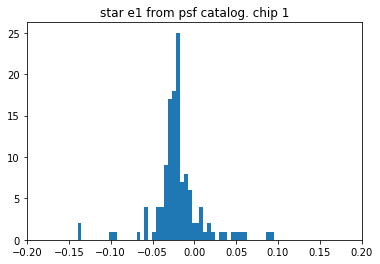

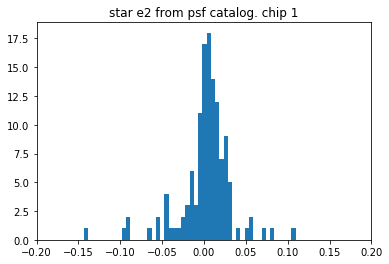

In [28]:
plt.figure()
plt.hist(psf_cat[1].data[psf_cat[1].data['ccdnum']==1]['obs_e1'], bins=50)
plt.xlim(-.2, .2)
plt.title('star e1 from psf catalog. chip 1')
plt.show()
plt.figure()
plt.hist(psf_cat[1].data[psf_cat[1].data['ccdnum']==1]['obs_e2'], bins=50)
plt.xlim(-.2, .2)
plt.title('star e2 from psf catalog. chip 1')
plt.show()

In [19]:
direc = '/Users/rebeccachen/Desktop/Piff_work/y3_test/'
# measure star shape/size from self-made piff chip 1
full_image = galsim.fits.read(direc+'D00383252_r_c'+'01'+'_r2277p01_immasked.fits', hdu=1)
stamp_size = 48
fwhm = 0.8
x_cat = pf.open(direc+'383252_c'+'01'+'.fits')[1].data['x']
y_cat = pf.open(direc+'383252_c'+'01'+'.fits')[1].data['y']

star_e1 = []
star_e2 = []
star_sizes = []
for i in range(len(x_cat)):
    x = x_cat[i]
    y = y_cat[i]
    b = galsim.BoundsI(int(x)-stamp_size/2, int(x)+stamp_size/2, int(y)-stamp_size/2, int(y)+stamp_size/2)
    b = b & full_image.bounds
    im = full_image[b]
    dx, dy, g1, g2, T, flux, flag = hsm(im, None, logger)
#     dx, dy, g1, g2, T, flux, flag = ngmix_fit(tempimg, None, fwhm, x_cat[i], y_cat[i], logger)
    star_e1.append(g1)
    star_e2.append(g2)
    star_sizes.append(T)

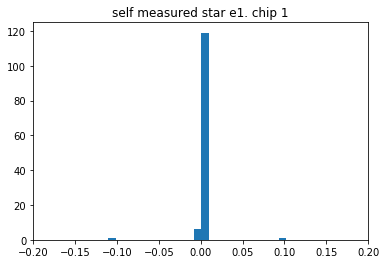

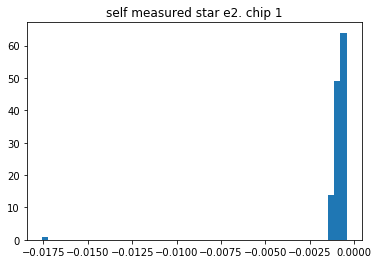

In [32]:
plt.figure()
plt.hist(star_e1, bins=50)
plt.xlim(-.2, .2)
plt.title('self measured star e1. chip 1')
# not even using piff model. just measurement
plt.show()
plt.figure()
plt.hist(star_e2, bins=50)
# plt.xlim(-.2, .2)
plt.title('self measured star e2. chip 1')
# not even using piff model. just measurement
plt.show()

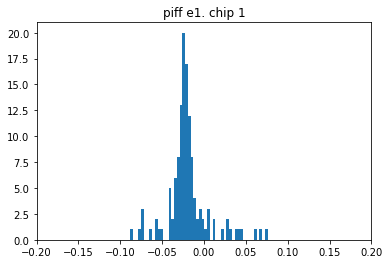

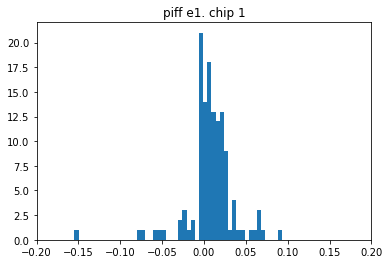

In [34]:
plt.figure()
plt.hist(psf_cat[1].data[psf_cat[1].data['ccdnum']==1]['piff_e1'], bins=50)
plt.xlim(-.2, .2)
plt.title('piff e1. chip 1')
plt.show()
plt.figure()
plt.hist(psf_cat[1].data[psf_cat[1].data['ccdnum']==1]['piff_e2'], bins=50)
plt.xlim(-.2, .2)
plt.title('piff e1. chip 1')
plt.show()

In [31]:
# self piff model measurement for stars
piff_e1 = []
piff_e2 = []
piff_sizes = []
piffdir='/Users/rebeccachen/Piff/y3_test/output/'
chip_num = "%.2d" % 1
psf = piff.read(piffdir+'383252_c'+chip_num+'.piff')
x_cat = pf.open(direc+'383252_c'+chip_num+'.fits')[1].data['x']
y_cat = pf.open(direc+'383252_c'+chip_num+'.fits')[1].data['y']
for i in range(len(x_cat)):
    temp = psf.draw(x_cat[i], y_cat[i])
    galsim.fits.write(temp, 'temp.fits', piffdir)
    tempimg = galsim.fits.read('temp.fits', piffdir)
    dx, dy, g1, g2, T, flux, flag = hsm(temp, None, logger)
#     dx, dy, g1, g2, T, flux, flag = ngmix_fit(tempimg, None, fwhm, x_cat[i], y_cat[i], logger)
    piff_e1.append(g1)
    piff_e2.append(g2)
    piff_sizes.append(T)

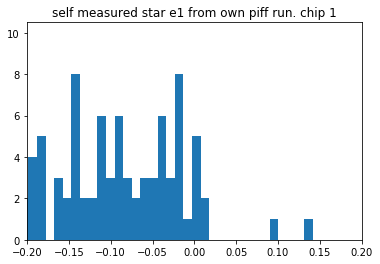

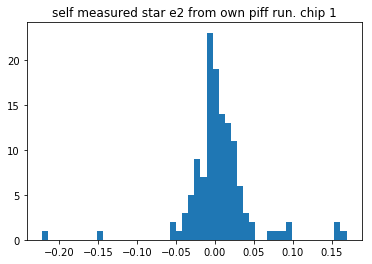

In [33]:
plt.figure()
plt.hist(piff_e1, bins=50)
plt.xlim(-.2, .2)
plt.title('self measured star e1 from own piff run. chip 1')
plt.show()
plt.figure()
plt.hist(piff_e2, bins=50)
# plt.xlim(-.2, .2)
plt.title('self measured star e2 from own piff run. chip 1')
plt.show()